# Cross-View Image Retrieval (CVIR)

In this part, we'll be implementing a Cross-View Image Retrieval System. You have probably heard about Content Based Image Retrieval Systems (CBIR) where we have a database of images and given a query image, we will return similar images based on their features (Basically, Google Image Search). CVIR is a more complex problem, where your query image will have a different *view* and you will search for similar images in a different view which contain the same semantic information. For instance, you may have a satellite image of a river, and when you pass this in a CVIR, it should return images of rivers taken from the ground-level view (or street view).

Here's an overview of the system we will be implementing in this assignment:

- **Feature Extraction**: In this component, we will train a CNN that will extract useful features of a query image. We will use transfer learning to fine-tune a VGG16 model.    
- **Similarity Matching**: This is the core of our system. Here we will find the similarity between the feature vector extracted from the query image, and the feature vectors of search images, and assign similarity scores. We will perform this for each image in the database and store their scores.     
- **Retrieval**: Once we have scores for each query image, we will sort these results based on the similarity scores, with the most similar (i.e. has the smallest distance) being on the top, and the least similar (i.e. has the largest distance) being at the bottom. Finally we will return the retrieved images.

### IMPORTANT: Enter your Roll Number in the cell below

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
#zip_ref = zipfile.ZipFile('/content/drive/My Drive/DLAS4.zip','r')
zip_ref = zipfile.ZipFile('/content/drive/My Drive/DLAS4/DLAS4.zip','r')
zip_ref.extractall('/content/images2')
zip_ref.close()

In [0]:
ROLLNUMBER = 21100086

NUM_CLASSES = 6
labels_dict = {"freeway":0,"mountain":1,"palace":2,"river":3,"ship":4,"stadium":5}

# Batch size is a hyperparameter, feel free to change this. You may also change the number of epochs.
BATCH_SIZE = 32
EPOCHS = 5

In [0]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU, Input, concatenate, add, Reshape, Conv2D, Activation
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, SGD
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from glob import glob
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import collections
import os
from scipy.spatial.distance import cosine
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImageDataGenerator
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

## Task 1 - Loading Data
You have been provided with Images from two different views: Street (Ground Level) and Satellite. Each of these views contain images of 6 classes: Freeway, Mountain, River, Ship, Stadium, and Palace. We know you guys loved creating Data Generators, but for this task we will be using built-in Image Generators in TensorFlow. <br> 

Additionally, we can also augment data in real-time using these generators. Data Augmentation is an important technique of generalizing your models even more for unseen data. We can augment Image data by manipulating it, which keeps all the semantic information but can essentially be treated as new data. For instance, we can rotate, flip, zoom-in an Image and this image will be treated as a new data point in addition to our current dataset.

**IMPORTANT: You may augment data, but that would mean running a lot of epochs to train your models, since we have not trained our models on augmented data**

### Using Built-In Data Generator
First, we will create ImageDataGenerator objects, which allows you to add methods to augment data in real-time as well as pre-process it. Read the documentation to get a good grip of it: [Image Pre-processing](https://keras.io/preprocessing/image/#imagedatagenerator-class)

Create an ImageDataGenerator object for training and only set the validation_split argument. (If you want to augment data and train your model for more epochs, you may add arguments for augmenting data)

In [0]:
train_aug = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format='channels_last', validation_split=0.3, dtype='float32')

Now, create data generators (Train and Validation for **EACH** view) using the flow_from_directory method of the ImageDataGenerator object. Pass in the appropriate arguments.     
**IMPORTANT:**
 - Target size should be (224,224).
 - For the training generators pass in subset='training' in flow_from_directory and similarly for the validation generators, pass in subset='validation'.
 - Also pass in seed=ROLLNUMBER

In [9]:
t_g_sat = train_aug.flow_from_directory(
       directory="./images2/SatView/Images",subset="training",
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',seed=ROLLNUMBER)
v_g_sat = train_aug.flow_from_directory(
        directory="./images2/SatView/Images",subset="validation",
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',seed=ROLLNUMBER)
t_g_str = train_aug.flow_from_directory(
       directory="./images2/StreetView/Images",subset="training",
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',seed=ROLLNUMBER)
v_g_str = train_aug.flow_from_directory(
       directory="./images2/StreetView/Images",subset="validation",
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',seed=ROLLNUMBER)

Found 2940 images belonging to 6 classes.
Found 1260 images belonging to 6 classes.
Found 3737 images belonging to 6 classes.
Found 1598 images belonging to 6 classes.


Feel free to explore the attributes and methods in the data generator created above. Some important ones are: filepaths (Returns a list of all files found in the specified directory), n (Number of files, this will be useful when passing in the steps_per_epoch argument in fit_generator), labels (Labels corresponding to the filepaths)

## Task 2 - Classification Models
In order to extract discriminative features, we will imply transfer learning and use VGG16 (pre-trained on ImageNet) models to fine-tune them for our purpose. These models will be used to perform image classification for images in each view. We will be training a separate model for each view.

### Create an Instance of a pre-trained VGG16 Model
We'll create an instance of a VGG16 model (pre-trained on Imagenet) that is available in the Keras Applications module. Refer to the applications module to learn more about using pre-trained models: [Keras Applications](https://keras.io/applications/).

When we create an instance of a pre-trained model, we set include_top to False, which will remove all Dense layers from the "head" of the model. We do this since we want to use the model for, say a 10-class classification task instead of ImageNet's 1000-class task. For the weights, we will pass in 'imagenet' since we want to utilize features learned from the ImageNet dataset. Lastly, we can define the input_shape that our model should expect, i.e. (224,224,3) in our case since we will be resizing images to match the input shape of VGG16.

In [10]:
base_model_sat = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=None, classes=6)
base_model_str = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=None, classes=6)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
base_model_sat._name = "sat_base_model"
base_model_str._name = "str_base_model"

### Adding additional layers to fine-tune the model
 When we want to use transfer learning to fine-tune a model trained on a problem similar to ours, we tweak the "head" of the model to meet our requirements. The models loaded above have no dense layers, so we will add a couple of dense layers and **TRAIN ONLY THOSE DENSE LAYERS** while <strong>*freezing*</strong> all other layers. We will include the following layers to our base VGG16 models:
 
 - Flatten
 - Dense layer with 1024 units and ReLu activation
 - Dropout with parameter 0.4
 - Dense layer with 1024 units and ReLu activation
 - Dropout with parameter 0.5
 - Dense layer with NUM_CLASSES and softmax activation

Using the Functional API of Keras, add the aforementioned layers to both models.     
**Note: For the Flatten layer, the input will be the output of the last layer of the base model, i.e. base_model.output.**

In [0]:
# Add layers to your Satellite Base Model
f=(tf.keras.layers.Flatten())(base_model_sat.output)
f=(tf.keras.layers.Dense(1024, activation='relu'))(f)
f=tf.keras.layers.Dropout(rate=0.4)(f)
f=(tf.keras.layers.Dense(1024, activation='relu'))(f)
f=(tf.keras.layers.Dropout(rate=0.5))(f)
f=(tf.keras.layers.Dense(6, activation='softmax'))(f)


In [0]:
# Add layers to your Street Base Model
f1=(tf.keras.layers.Flatten())(base_model_str.output)
f1=(tf.keras.layers.Dense(1024, activation='relu'))(f1)
f1=tf.keras.layers.Dropout(rate=0.4)(f1)
f1=(tf.keras.layers.Dense(1024, activation='relu'))(f1)
f1=(tf.keras.layers.Dropout(rate=0.5))(f1)
f1=(tf.keras.layers.Dense(6, activation='softmax'))(f1)

Now, create new Models using the Model constructor

In [0]:
sat_classification_model =tf.keras.Model(inputs=base_model_sat.inputs,outputs=f)
str_classification_model =tf.keras.Model(inputs=base_model_str.inputs,outputs=f1)

In [0]:
sat_classification_model._name = 'sat_classification_model'
str_classification_model._name = 'str_classification_model'

View the model summary for each model and verify if your model is correct

In [16]:
sat_classification_model.summary()
str_classification_model.summary()

Model: "sat_classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56

Before we compile our classification models, we need to *freeze* the layers of our **base_models**. If we don't do this then we will be retraining the VGG16 model and we don't want that because: 1) The filters that the pre-trained VGG16 has learned on ImageNet are most probably already very good in terms of finding features of images, so we usually don't need to re-train these layers 2) Our machines will probably die.

In order to freeze these layers, we will iterate over base_model.layers and for each layer L we will freeze it by setting L.trainable to False. Do this for both models below

In [0]:
# Freeze layers for BOTH models
for a in base_model_str.layers:
  a.trainable=False

for a in base_model_sat.layers:
  a.trainable=False

Now, we can compile our models. You already know how to do this (Hopefully)

In [0]:
# Compile
adam = Adam(lr=0.001)
sat_classification_model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])


str_classification_model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

### Training the Classification Model
Your favourite part. Model.fit and that's about it.

Add any callbacks you want to here (I would recommend adding at least the ModelCheckpoint so you can resume training)

**Note:** For Carrying out training in intervals you can 

1.   List item
2.   List item

save your best models to disk and then stop your training. Whenever you wish to resume your training, you can load this model using load_model, and then call fit_generator on it. <br> In fit_generator, you will need to pass in initial_epoch as well in order to retain epoch-dependent objects such as optimizers, which will be the epoch number of the model you loaded. Secondly, you will need to set epochs relative to this initial_epoch. For instance, if your loaded model corresponds to epoch 10, and you want to train your model for 10 epochs, you will pass in initial_epoch=10 and epochs=20, not 10, since your model has already been trained for 10 epochs, and you want to train it for 10 more epochs.

In [0]:
# Callbacks for Satellite Model
if not os.path.exists('Models'):
    os.mkdir('Models/')
  
checkpoint = ModelCheckpoint(sat_classification_model._name+'/'+sat_classification_model._name+'.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')
    
callbacks1=[checkpoint]



In [0]:
# Callbacks for Street Model
if not os.path.exists('Models'):
    os.mkdir('Models/')

checkpoint = ModelCheckpoint(str_classification_model._name+'/'+str_classification_model._name+'.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')
    
callbacks2=[checkpoint]


In order to give you a head start we've already trained the models for you for some epochs yielding decent validation accuracy. Load these **weights** using model.load_weights

In [0]:
# Load weights for BOTH models
sat_classification_model.load_weights('./images2/sat_weights')
str_classification_model.load_weights('./images2/str_weights')

In [0]:
tg1=t_g_sat
vg1=v_g_sat
tg2=t_g_str
vg2=v_g_str

Train it for a couple of more epochs (At least 1-2). You may reduce the batch_size if memory is an issue for you. Additionally, check out the workers and use_multiprocessing arguments of fit_generator to speed up training.

In [0]:
#DONT U DARE
sat_hist = sat_classification_model.fit_generator(tg1, epochs=3, steps_per_epoch=tg1.n//BATCH_SIZE
                                   ,callbacks=callbacks1,validation_steps=vg1.n//BATCH_SIZE,
                           validation_data=vg1
                           ,verbose=1,use_multiprocessing=True,workers=6)

Epoch 1/3
91/91 [==============================] - ETA: 0s - loss: 18.5771 - accuracy: 0.8637 WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `tf.data.Dataset`.

Epoch 00001: val_loss improved from inf to 24.80431, saving model to sat_classification_model/sat_classification_model.h5
91/91 [==============================] - 2106s 23s/step - loss: 18.5771 - accuracy: 0.8637 - val_loss: 24.8043 - val_accuracy: 0.8005
Epoch 2/3
91/91 [==============================] - ETA: 0s - loss: 5.1570 - accuracy: 0.9045 WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `tf.data.Dataset`.

Epoch 00002: val_loss improved from 24.80431 to 4.70335, saving model to sat_classification_model/sat_classification_model.h5
91/91 [==============================] - 2141s 24s/step - loss: 5.1570 - accuracy: 0.9045 - val_loss: 4.7033 

In [0]:
str_hist = str_classification_model.fit_generator(tg2, epochs=2, steps_per_epoch=tg2.n//BATCH_SIZE
                                   ,callbacks=callbacks2,validation_steps=vg2.n//BATCH_SIZE,
                           validation_data=vg2
                           ,verbose=1,use_multiprocessing=True,workers=6)

Epoch 1/2
116/116 [==============================] - ETA: 0s - loss: 8.0341 - accuracy: 0.9036 WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `tf.data.Dataset`.

Epoch 00001: val_loss improved from 4.75091 to 3.03168, saving model to str_classification_model/str_classification_model.h5
116/116 [==============================] - 3090s 27s/step - loss: 8.0341 - accuracy: 0.9036 - val_loss: 3.0317 - val_accuracy: 0.9381
Epoch 2/2
116/116 [==============================] - ETA: 0s - loss: 3.5106 - accuracy: 0.9477 WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `tf.data.Dataset`.

Epoch 00002: val_loss did not improve from 3.03168
116/116 [==============================] - 3118s 27s/step - loss: 3.5106 - accuracy: 0.9477 - val_loss: 6.0209 - val_accuracy: 0.9190


### Model Analysis
The part you probably dread the most.

In [0]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Plot losses and accuracies for both models.

##### Satellite Model

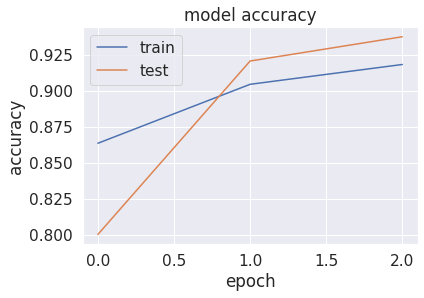

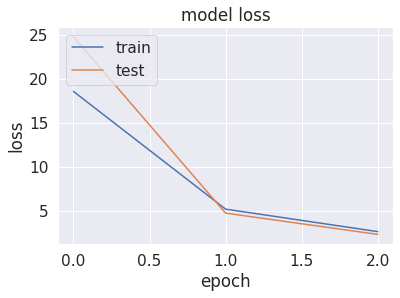

In [0]:
plot_accuracy(sat_hist)
plot_loss(sat_hist)

In [0]:
'''
for the sat model we see that the test performs better than the train which can be attributed to the dropout
training loss is slightly higher because we have artifically made it harder for the network to perfom well but 
during the validation stage when nothing has been dropped the model can work better
'''

##### Street Model

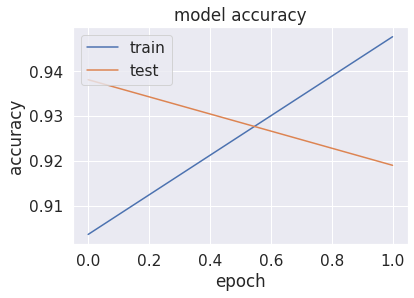

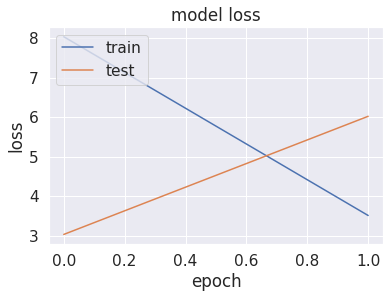

In [0]:
plot_accuracy(str_hist)
plot_loss(str_hist)

In [0]:
'''
for str model the training metrics perform better than the validation metrics, and the latter fluctuate between
reasonable limits
'''

Q) You may observe that your validation metrics are better than your training metrics. Explain how this is possible? <br>
Answer:

In [0]:
'''
answered above
'''

#### Confusion Matrix
For each model, evaluate the model on the validation set (using the val_generators) then compute and print the confusion matrix. Pick appropriate evaluation metrics for a typical classification task and then comment on these metrics while justifying your reason for choosing these metrics (e.g. Talking about Precision and why precision is important etc.). Also, check and comment if your model is confused between some classes and explain why do you think that confusion lies in your opinion.
<br> Use Sci-kit Learn to compute the confusion matrix and plot it.

In [0]:
'''
Precision is a the ratio between True positive/(True positive and false positive) it helps us detemine whether 
a multi-classification task has indeed been performed accurately. a higher precision means a better classification 
for the class
'''

In [0]:
def plot_confusion_matrix(conf_mat):
    classes = ['freeway', 'mountain', 'palace', 'river', 'ship', 'stadium']
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

###### Satellite

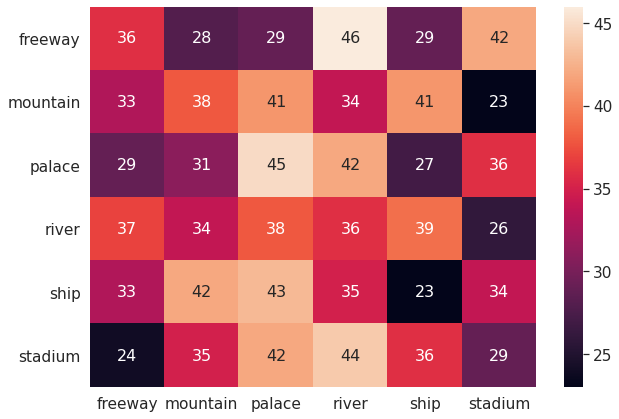

In [0]:
# Evaluation Metrics and Confusion Matrix for the satellite model
sat_pred=sat_classification_model.predict_generator(vg1,vg1.n//BATCH_SIZE+1)
VSat_pred = np.argmax(sat_pred, axis=1)
conf_mat=confusion_matrix(vg1.classes,VSat_pred)
plot_confusion_matrix(conf_mat)

In [28]:

'''
Manually calculated because of internet issues
precision
free way=0.1875
mountain=0.183
palace=0.189
river=0.15
ship=0.117
stadium=0.153
recall
free way=0.171
mountain=0.181
palace=0.214
river=0.171
ship=0.109
stadium=0.138
the ship class is not very good with a low precision and low recall rate.
it rarely identifies ships correctly
mountain and freeway both perform well
palace has a high recall and low percision meaning that 
most of the positive examples are correctly recognized but there are a lot of false positives.
'''

'\nManually calculated because of internet issues\nprecision\nfree way=0.1875\nmountain=0.183\npalace=0.189\nriver=0.15\nship=0.117\nstadium=0.153\nrecall\nfree way=0.171\nmountain=0.181\npalace=0.214\nriver=0.171\nship=0.109\nstadium=0.138\nthe ship class is not very good with a low precision and low recall rate.\nit rarely identifies ships correctly\nmountain and freeway both perform well\npalace has a high recall and low percision meaning that \nmost of the positive examples are correctly recognized but there are a lot of false positives.\n'

###### Street

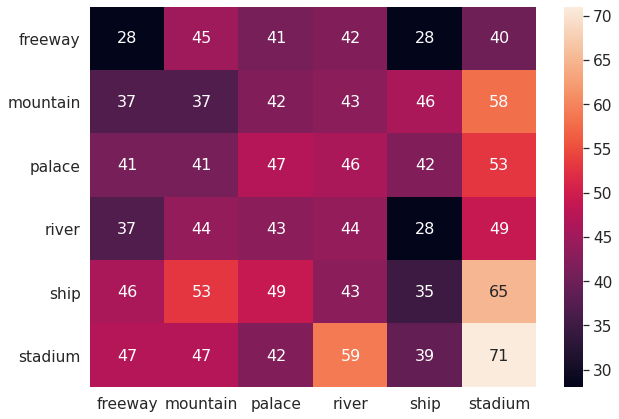

In [0]:
# Evaluation Metrics and Confusion Matrix for the satellite model
str_pred=str_classification_model.predict_generator(vg2,vg2.n//BATCH_SIZE+1)
VSttr_pred = np.argmax(str_pred, axis=1)
conf_mat=confusion_matrix(vg2.classes,VSttr_pred)
plot_confusion_matrix(conf_mat)

In [0]:
'''
Manually calculated because of internet issues
precision
free way=0.118
mountain=0.138
palace=0.178
river=0.16
ship=0.16
stadium=0.211
recall
free way=0.125
mountain=0.14
palace=0.174
river=0.179
ship=0.12
stadium=0.232

with high precision and high recall stadium performs the best
freeway and mountain both perform poorly 



'''

## Task 3 - Similarity Matching
This is the core of our CVIR system, where feature vectors of query images and search images will be compared and assigned a similarity score (or distance between these two vectors). We will be using the following distance metrics in order to compute similarity (distance is opposite of similarity,lower distance means more similar):

- Cosine
- DML

### Distance Metric Learning (DML)
Just like cosine, euclidean, and other metrics to compute distances between two feature vectors, we can create a Neural Network that can compute a distance metric for us given two input feature vectors. We will train a DML, (More about this: [ICONIP-CVIR](https://www.researchgate.net/publication/337862425_Cross-View_Image_Retrieval_-_Ground_to_Aerial_Image_Retrieval_Through_Deep_Learning)) which will take two feature vectors as input and output a label: 0 (Match, i.e. 0 distance between them) or 1 (No match, i.e. completely dissimilar feature vectors). The output layer of this DML will have a sigmoid activation and will output a continuous value between 0 and 1 which will be treated as the distance between these two feature vectors.

We're providing you with the Model Architecture, use this to create a Keras model using the Functional API:     
![DML](DML_Structure1.png)

In [0]:
def DML():
  i1=Input(shape=(1024,1))
  i2=Input(shape=(1024,1))
  r1=Reshape((32,32,1))(i1)
  r2=Reshape((32,32,1))(i2)
  f=concatenate([r1,r2])
  f1=Conv2D(16,kernel_size=(3,3),activation='relu',padding='same')(f)
  f2=Conv2D(16,kernel_size=(3,3),activation='relu',padding='same')(f1)
  f3=Conv2D(16,kernel_size=(3,3),activation='relu',padding='same')(f2)
  f4=tf.keras.layers.add([f1,f3])
  f5=Conv2D(16,kernel_size=(3,3),activation='relu',padding='same',strides=(2,2))(f4)
  f6=Conv2D(16,kernel_size=(3,3),activation='relu',padding='same',strides=(2,2))(f4)
  f7=Conv2D(16,kernel_size=(3,3),activation='relu',padding='same')(f6)
  f8=tf.keras.layers.add([f5,f7])
  f9=tf.keras.layers.LeakyReLU(alpha=0.3)(f8)
  f10=Flatten()(f9)
  f11=Dense(1024, activation='relu')(f10)
  f12=LeakyReLU(alpha=0.3)(f11)
  f13=Dense(512, activation='relu')(f12)
  f14=LeakyReLU(alpha=0.3)(f13)
  f15=Dense(64, activation='relu')(f14)
  f16=LeakyReLU(alpha=0.3)(f15)
  f17=Dense(1, activation='sigmoid')(f16)
  return Model(inputs=[i1,i2],outputs=f17)

In [0]:
dml = DML()
dml._name='dmlm'
dml.summary()

Model: "dmlm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 32, 32, 1)    0           input_5[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 32, 32, 1)    0           input_6[0][0]                    
_______________________________________________________________________________________________

#### Training the DML
We'll be providing you with DataFrames that contain the Train and Test data. You will realize that it is very useful to know how to create data generators when you want to yield data in a custom format. Use the DataFrame provided to create a generator and train your model. When yielding data be careful about your structure. The DML expects two inputs, so your generator should yield in this format: <br>  ( [ Satellite Feature Vector, Street Feature Vector ] ,Label )

Load the DataFrames

In [0]:
dml_train_df = pd.read_csv('/content/images2/dml_train.csv')
dml_test_df = pd.read_csv('/content/images2/dml_test.csv')

**IMPORTANT**: Training the DML can take very long considering the overhead (Loading image, Passing it in the Feature Vector Extraction model to get the feature vector, yielding this Feature Vector in the generator).    
In order to speed up training and reduce this overhead, we can perform the training in two passes:

1) Use Feature Vector Extraction Models to extract feature vectors and store this feature vectors to disk.
2) Create a Data Generator that loads yields these feature vectors to train the DML

We have already performed step 1 for you using the pre-trained weights provided to you. The features of each image are stored in the Features/ directory. The paths are already included in the dataframes provided to you.

Q: How would you extract feature vectors from your classification models if we treat the output of the last 1024 dense layer as the Feature Vector of an Image? Write a code snippet that creates a model (Using either sat/str classification model) that takes an Image as an input and outputs its feature vector. Print this model's summary

In [32]:
# Answer - Write your code in this cell
'''
fv extractor: we can take the output of the 1024 dense layer as the featur vector

f1=(tf.keras.layers.Flatten())(base_model_sat.output)
f1=(tf.keras.layers.Dense(1024, activation='relu'))(f1)
f1=tf.keras.layers.Dropout(rate=0.4)(f1)
f1=(tf.keras.layers.Dense(1024, activation='relu'))(f1)
sat_classification_model =tf.keras.Model(inputs=base_model_sat.inputs,outputs=f1)
sat_classification_model._name='fdsfds'
sat_classification_model.summary()
'''

Model: "fdsfds"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

**Note**: If you want to use your trained model to recompute features and train the DML on your own feature vectors, you're free to do that. Run the function below but it will take very long to compute the features. You can optimize this function by carrying computations in batches if you want to.

In [0]:
def compute_features():
    sat_imgs = glob('SatView/Images/**/*')
    str_imgs = glob('StreetView/Images/**/*')
    
    if not os.path.exists('SatView/Features'):
        os.mkdir('SatView/Features')
    if not os.path.exists('StreetView/Features'):
        os.mkdir('StreetView/Features')
    print("Computing for Satellite Images")
    for f in sat_imgs:
        img = get_image(f)
        base_path = 'SatView/Features/'
        filename = f.split('/')[-1].split('.')[0]
        ext = '.npy'
        fv = sat_fv_extractor.predict(np.expand_dims(img,axis=0)).reshape(1024,1)
        save_at = base_path + filename + ext
        if not os.path.exists(save_at):
            np.save(save_at,fv)
            
    print("Computing for Street Images")
    for f in str_imgs:
        img = get_image(f)
        base_path = 'StreetView/Features/'
        filename = f.split('/')[-1].split('.')[0]
        ext = '.npy'
        fv = str_fv_extractor.predict(np.expand_dims(img,axis=0)).reshape(1024,1)
        save_at = base_path + filename + ext
        if not os.path.exists(save_at):
            np.save(save_at,fv)

Create a Data Generator for training the DML

In [0]:
def dml_data_generator(df, batch_size = 32, mode='train'):
  while True:
    sat = []
    sttr = []
    lab = []
    index=0
    for i in range(len(df.index)):
      sat.append(np.load("/content/images2/"+df.sat_path.iloc[i]))
      sttr.append(np.load("/content/images2/"+df.str_path.iloc[i]))
      lab.append(int(df.label.iloc[i]))
      if (len(sat)==batch_size):
        yield ([np.array(sat),np.array(sttr)],np.array(lab))
        sat=[]
        sttr=[]
        lab=[]
 


   

In [0]:
dml_train_gen = dml_data_generator(dml_train_df,batch_size=BATCH_SIZE)
dml_test_gen = dml_data_generator(dml_test_df,batch_size=BATCH_SIZE)

Add any callbacks you want to

In [0]:
# Callbacks for DML go here
if not os.path.exists('Models'):
    os.mkdir('Models/')
checkpoint = ModelCheckpoint(dml._name+'/'+dml._name+'.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks5=[checkpoint]

In [0]:
adam = Adam(lr=0.0005)
dml.compile(loss='binary_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

Now, train the DML model on the provided dataset. You are free to tweak the hyperparameters of this model. Unlike the previous assignment, the accuracy of your DML will matter when grading your assignment. You can try different optimizers, learning rates, and if you want to, you can tweak the DML model as well but the overall structure should remain the same.

In [0]:
index=0
dml_hist = dml.fit_generator(dml_train_gen, epochs=5, steps_per_epoch=len(dml_train_df.index)//BATCH_SIZE
                                   ,callbacks=callbacks5,validation_data=dml_test_gen,validation_steps=len(dml_test_df.index)//BATCH_SIZE
                           ,verbose=1,workers=6,use_multiprocessing=True)

Epoch 1/5
1050/1050 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.5448WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `tf.data.Dataset`.

Epoch 00001: val_loss improved from inf to 0.69000, saving model to dmlm/dmlm.h5
1050/1050 [==============================] - 188s 179ms/step - loss: 0.6793 - accuracy: 0.5448 - val_loss: 0.6900 - val_accuracy: 0.4914
Epoch 2/5
1050/1050 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.6310WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `tf.data.Dataset`.

Epoch 00002: val_loss improved from 0.69000 to 0.61306, saving model to dmlm/dmlm.h5
1050/1050 [==============================] - 188s 179ms/step - loss: 0.6081 - accuracy: 0.6310 - val_loss: 0.6131 - val_accuracy: 0.6611
Epoch 3/5
1050/1050 [=========================

###### Plot DML Accuracy and Loss

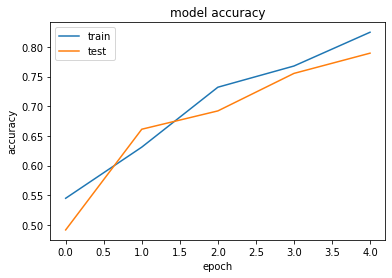

In [0]:
plot_accuracy(dml_hist)

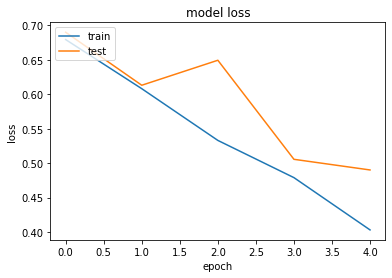

In [0]:
plot_loss(dml_hist)

Q) Comment on your DML model's bias and variance. <br>
Answer:

### Computing Similarity between Query Image and a Search Image

In [0]:
def sort_by_value(dict_obj):
    return collections.OrderedDict(sorted(dict_obj.items(), key=lambda kv: kv[1]))

Create a function that takes in a query image's Feature Vector (Or its path more precisely, a real system takes in a image but for our purposes we'll use feature vectors to speed up retrieval), and a Database which contains images their view and class labels (This will be provided to you). In this function you need to:    
    - Load the Feature Vector of the Query Image
    - For each image OF THE OPPOSITE VIEW in the database:
            - Load the feature vector of the search image
            - Get a distance score based on the metric argument
            - Store the result
    - Store all results in a Python Dictionary in which the keys are the paths to retrieved images, and values are the distance scores.
    - Return the sorted results dictionary (Use the sort_by_value function)

**IMPORTANT:** When passing in inputs to the DML in predict, you need to reshape your reshape your Feature Vector to (1,1024,1). It's the same as saying that you're passing in data with a batch_size of 1. You can predict in batches but then you will also need to figure out how to store the results in the final sorted dictionary.

The get_similar function will expect a DataFrame (Database arugment) that stores information about the images in our database, you don't have to worry about this since we will provide you with this DataFrame.

In [0]:
# Load your best DML Model here
dml = dml

In [0]:
def get_similar(query_fv_path,database,metric='dml',query_view='str',batch_size=32):
    results={}
    
    if query_view == 'str':
      q=np.load(query_fv_path)
      q=q.reshape(1,1024,1)
      for i in range(len(database.view)):
        if database.view.iloc[i]=='sat':
          path="/content/images2/"+database.fv_path.iloc[i]
          path2='/content/images2/'+database.img_path.iloc[i]
          d=np.load(path)
          d=d.reshape(1,1024,1)        
          results[path2]=(dml.predict([d,q],32))
      
        
    elif query_view == 'sat':
      q=np.load(query_fv_path)
      q=q.reshape(1,1024,1)
      for i in range(len(database.view)):
        if database.view.iloc[i]=='str':
          path="/content/images2/"+database.fv_path.iloc[i]
          path2='/content/images2/'+database.img_path.iloc[i]
          d=np.load("/content/images2/"+database.fv_path.iloc[i])
          d=d.reshape(1,1024,1)        
          results[path2]=(dml.predict([d,q],batch_size))
            

    return sort_by_value(results)

In [0]:
def get_similarcc(query_fv_path,database,metric='dml',query_view='str',batch_size=32):
    results={}
    
    if query_view == 'str':
      q=np.load(query_fv_path)
      q=q.reshape(1,1024,1)
      for i in range(len(database.view)):
        if database.view.iloc[i]=='sat':
          path="/content/images2/"+database.fv_path.iloc[i]
          path2='/content/images2/'+database.img_path.iloc[i]
          d=np.load(path)
          d=d.reshape(1,1024,1)        
          results[path2]=(cosine(q,d))
      
        
    elif query_view == 'sat':
      q=np.load(query_fv_path)
      q=q.reshape(1,1024,1)
      for i in range(len(database.view)):
        if database.view.iloc[i]=='str':
          path="/content/images2/"+database.fv_path.iloc[i]
          path2='/content/images2/'+database.img_path.iloc[i]
          d=np.load("/content/images2/"+database.fv_path.iloc[i])
          d=d.reshape(1,1024,1)        
          results[path2]=(cosine(q,d))
            

    return sort_by_value(results)

## Task 4 - Image Retrieval
Now its time to put it all together and run our CVIR system.

In [0]:
def view_results(results_dict,n=5):
    fig = figure(figsize=(15,15))
    files = list(results_dict.keys())
    for i in range(n):
        a=fig.add_subplot(1,n,i+1)
        image = imread(files[i])
        imshow(image)
        axis('off')

In [0]:
def get_db(df,imgs_per_classes=5):
    classes = ['freeway','mountain','palace','river','ship', 'stadium']
    sat_df = df[df['view'] == 'sat']
    str_df = df[df['view'] == 'str']
    db = pd.DataFrame({},columns=df.columns)
    for c in classes:
        sat_sample = sat_df[sat_df['class'] == c].sample(imgs_per_classes,random_state=ROLLNUMBER)
        str_sample = str_df[str_df['class'] == c].sample(imgs_per_classes,random_state=ROLLNUMBER)
        db = pd.concat([db,sat_sample,str_sample])
    return db.sample(frac=1,random_state=ROLLNUMBER).reset_index(drop=True)

In [0]:
#full_database = pd.read_csv('Retrieval_Database.csv')
full_database = pd.read_csv('/content/images2/Retrieval_Database.csv')

In [0]:
database = get_db(full_database,imgs_per_classes=5)

Finally, put all functions together to perform a search. We will be using **Street View Images as our queries** <br>
For **EACH** class, pick one query image from the database provided to you, and then search for its results. **You also need to perform these searches for BOTH metrics (Cosine and DML)** and then analyze and comment on each metric's performance. Try and see if you can find queries/classes for which your system does not perform well.

In [0]:
def search(query_fv_path,database,dist_metric='dml',num_results=5):
    result=get_similar(query_fv_path,database,dist_metric)
    view_results(result,n=5)

In [0]:
def searchcc(query_fv_path,database,dist_metric='dml',num_results=5):
    result=get_similarcc(query_fv_path,database,dist_metric)
    view_results(result,n=5)

### Retrievals

##### Using Cosine Distance

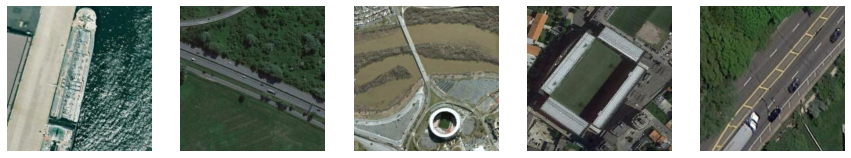

In [0]:
'Mountain'
path='/content/images2/StreetView/Features/14523174347_aca7fa5365_o.npy'
searchcc(path,database)

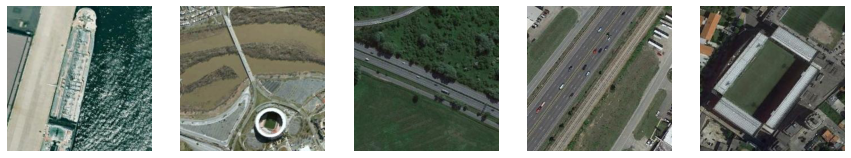

In [0]:
'stadium'
path='/content/images2/StreetView/Features/10086769384_d2451e0710_o.npy'
searchcc(path,database)

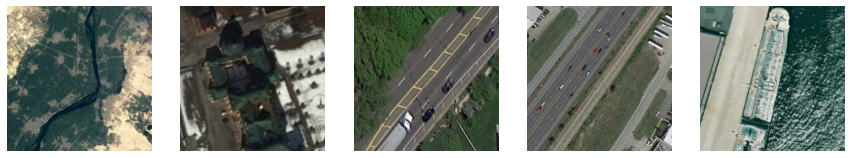

In [0]:
'ship'
path='/content/images2/StreetView/Features/46549749145_af4dbef3ff_o.npy'
searchcc(path,database)

##### Using the DML

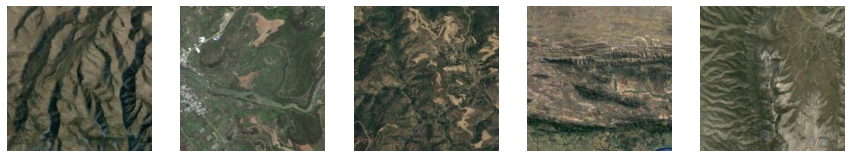

In [0]:
'Mountain'
path='/content/images2/StreetView/Features/14523174347_aca7fa5365_o.npy'
search(path,database)

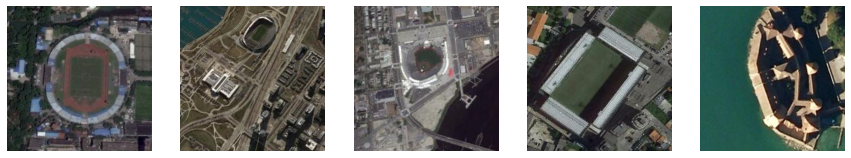

In [0]:
'stadium'
path='/content/images2/StreetView/Features/10086769384_d2451e0710_o.npy'
search(path,database)

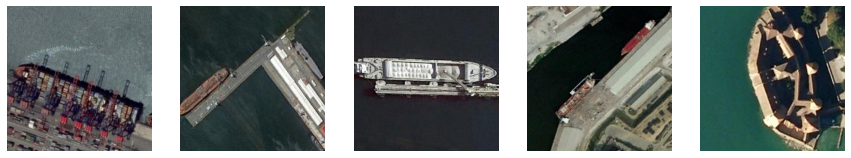

In [0]:
'ship'
path='/content/images2/StreetView/Features/46549749145_af4dbef3ff_o.npy'
search(path,database)

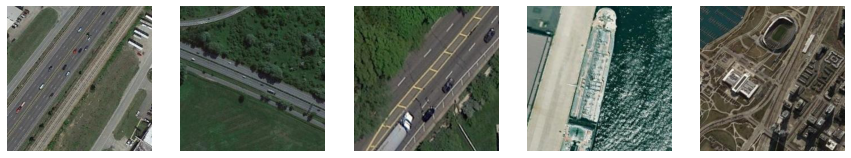

In [0]:
'freeway'
path='/content/images2/StreetView/Features/9460328156_692ccf9847_o.npy'
search(path,database)

#### Analysis
Write your analysis here and show any visualisations you want to here.

In [0]:
'''
we see that dml is much better at retrieving images as it has been trained and is able to calculate 
the distance much better than cosine which is at best able to retrieve similar photos for different 
search queries.
the picture for the same query displayed above is proof that while the DML can accurate spot 
5 pictures of mountains the cosine struggles to get even one.
'''